# Proyecto: Exploración de datos

In [2]:
#conda install keras

In [27]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from scipy.misc import imresize, imsave
import json
from copy import deepcopy
from sklearn.model_selection import train_test_split
from time import time #importamos la función time para capturar tiempos

print(os.path.abspath('.'))

import keras
from keras.datasets import mnist
from keras.models import *
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

C:\Users\thoma\Documents\GitHub\Proyecto-EL4106-


In [4]:
print(os.path.join('.','HiTS2013_100k_samples(4_channels)_images_labels.pkl'))

.\HiTS2013_100k_samples(4_channels)_images_labels.pkl


In [5]:
test_set_filename = 'HiTS2013_100k_samples(4_channels)_images_labels.pkl'

data = np.load(test_set_filename)

data.keys()

dict_keys(['images', 'labels'])

In [6]:
#print(type(data["images"][1]))
print('Imagenes por fenomeno:')
print(len(data["images"]))
print('Etiqueta del primer dato:')
print(data["labels"][0])
print('Dimension de cada imagen:')
data["images"][1][:,:,0].shape

Imagenes por fenomeno:
100000
Etiqueta del primer dato:
0
Dimension de cada imagen:


(21, 21)

Cada imagen es de 21x21, con cuatro dimensiones que serían cada canal. Se podría hacer el experimento de ver que canal concventra mayor información y si en verdad hay uno no más que apaña para entrenar.

La clase es 1, es decir, si es supernova.


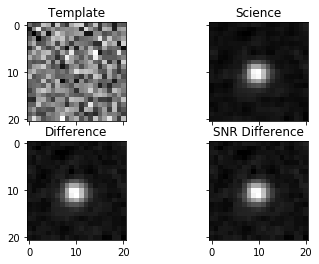

In [7]:
#acá se muestran las imagenes del priemer dato
X0 = data["images"][3][:,:,0]
X1 = data["images"][3][:,:,1]
X2 = data["images"][3][:,:,2]
X3 = data["images"][3][:,:,3]# sample 2D array


fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X0, cmap="gray")
axs[0, 0].set_title('Template')
axs[0, 1].imshow(X1, cmap="gray")
axs[0, 1].set_title('Science')
axs[1, 0].imshow(X2, cmap="gray")
axs[1, 0].set_title('Difference')
axs[1, 1].imshow(X2, cmap="gray")
axs[1, 1].set_title('SNR Difference')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

print('La clase es '+str(data["labels"][3])+', es decir, si es supernova.')

Para entrenar la red se deben procesar los datos para ser ingresados al clasificador. Si utilizamos una red convolucional, sirve que cada dato sea representado mediante cada una de sus fotos propiamente tal, a modo de feature map. Si se usa MLP, se cancatenaran vectores que contengan 528 elemento (cada imagen hecha vector) para generar una capa de 528x4 entradas.

Lo más coneveniente en este caso será usar una red convolucional, la forma del problema sugiere que con una red de este tipo habrá un mayor desempeño.

In [8]:
#prcesamiento de datos
#En esta parte se harán experimentos solo con 1000 elementos del dataset, se puede cambiar
num=80000

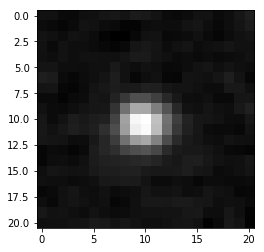

In [9]:
#Es importante hacerle el zero padding para tener mejor desempeño en una posible red convolucional
#Así también los mapas de oclusión habrán sido calculados con la misma cantidad de 'tapadas' para cada pixel
#Acá se genera el set con el que se entrenará el clasificador (sin oclusión todavía), a partir de una porciín del dict

def zero_pad(dataset,zero=True):
    datos_proc=[]
    if zero==True:
        for i in range(dataset.shape[0]):
            dato=dataset[i]#dato son las 4 fotos en 21x21x4
            dato=np.pad(dato, pad_width=1, mode='constant', constant_values=0)
            f_imag=dato[:,:,1:5]#Se retiran dos capas que se hicieron de ceros en las tapas del cubo
            datos_proc.append(f_imag)
        return datos_proc
    else:
        for i in range(dataset.shape[0]):
            dato=dataset[i]#dato son las 4 fotos en 21x21x4
            datos_proc.append(dato)
        return datos_proc
def labels(dataset):
    labels=[]
    for i in range(dataset.shape[0]):
        label=dataset[i]
        labels.append(label)
    return labels
    
datos_proce=zero_pad(data["images"][0:num])#este contiene las fotos con el zero pad
labels_proce=labels(data["labels"][0:num])
#ejemplo
datos_sPad=zero_pad(data["images"][0:num],False)#este contiene las fotos sin el zero pad
labels_proce=labels(data["labels"][0:num])
plt.imshow(datos_sPad[3][:,:,1], cmap="gray")

In [10]:
#Esta clase tiene por fin generar lás imágenes con sectores tapados
class OcclusionGenerator(object):
    #img es el arreglo numpy que contiene las
    #boxsize es el tamaño del parche
    #step es el paso que avanza el parche
    def __init__(self, img, boxsize=3, step=1, prepocess=True):
        ''' Initializations '''
        self.img = img
        self.boxsize = boxsize
        self.step = step 
        #creo que son las posiciones del parche
        self.i = 0
        self.j = 0
    

    def flow(self):
        ''' Return a single occluded image and its location '''
        if self.i + self.boxsize > self.img.shape[0]:
            return None, None, None
        
        retImg = np.copy(self.img)
        retImg[self.i:self.i+self.boxsize, self.j:self.j+self.boxsize] = 0.0 

        old_i = deepcopy(self.i) 
        old_j = deepcopy(self.j)
        
        # update indices
        self.j = self.j + self.step
        if self.j+self.boxsize>self.img.shape[1]: #reached end
            self.j = 0 # reset j
            self.i = self.i + self.step # go to next row
        
        
        return retImg, old_i, old_j
    def print(self):
        X0 = self.img[:,:,0]
        X1 = self.img[:,:,1]
        X2 = self.img[:,:,2]
        X3 = self.img[:,:,3]# sample 2D array


        fig, axs = plt.subplots(2, 2)
        axs[0, 0].imshow(X0, cmap="gray")
        axs[0, 0].set_title('Template')
        axs[0, 1].imshow(X1, cmap="gray")
        axs[0, 1].set_title('Science')
        axs[1, 0].imshow(X2, cmap="gray")
        axs[1, 0].set_title('Difference')
        axs[1, 1].imshow(X2, cmap="gray")
        axs[1, 1].set_title('SNR Difference')

# Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
    
    def getimg(self):
        return self.img
    
    def gen_minibatch(self, batchsize=10):
        ''' Returns a minibatch of images of size <=batchsize '''
        
        # list of occluded images
        occ_imlist = []
        locations = []
        for i in range(batchsize):
            occimg, i, j = self.flow()
            if occimg is not None:
                occ_imlist.append(occimg)
                locations.append([i,j])

        if len(occ_imlist)==0: # no data
            return None,None
        else:
            # convert list to numpy array and pre-process input (0 mean centering)
            x=reformat(occ_imlist)
            return x, locations


<class '__main__.OcclusionGenerator'>
<class 'numpy.ndarray'>
(21, 21, 4)
(21, 21, 4)


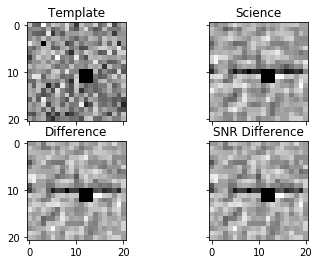

In [11]:
# testing out the occlusion generator class
img = datos_sPad[1]#así esta en 21x21x4
occ = OcclusionGenerator(img)
parche=occ.flow()
im=parche[0]
print(type(occ))
print(type(parche[0]))
print(im.shape)
occList = []#Esta lista va guardando las imagenes a medida que el parche va avanzando
#Se tiene preconfigurado en la clase un paso de 1 y un parche de 2x2
for i in range(528):
    occList.append(occ.flow()[0])
#ejemplo de imagen ocluida
example=OcclusionGenerator(occList[200])
print(occList[200].shape)
example.print()

(21, 21, 4)

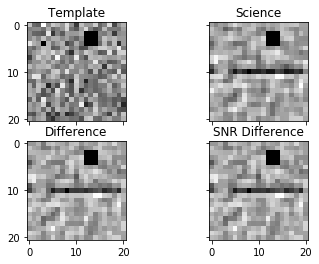

In [12]:
#Aca se crea una función para recibir un dato del diccionario data y devolver el set de imagenes con todas las oclusiones
#si se cambia el paso y el tamaño del filtro hay que alterar esta función para que calce (creo)
def OcGen(img):
    occ = OcclusionGenerator(img)
    occList = []#Esta lista va guardando las imagenes a medida que el parche va avanzando
#Se tiene preconfigurado en la clase un paso de 1 y un parche de 3x3
    for i in range(528):#aumentar este parametro se presta para data augmentation
        occList.append(occ.flow()[0])
    return occList
#Ejemplo de la imagen 350 del set de imagenes ocluidas del primer dato
example=OcclusionGenerator(OcGen(datos_sPad[1])[50])
example.print()
datos_sPad[1].shape

# Red a entrenar



In [43]:
#Antes de entrenar hay que generar los conjuntos de entrenamiento y test. El de entrenamiento tendrá un 0.9 de los datos
x_train, x_test, y_train, y_test = train_test_split(datos_sPad, labels_proce, test_size=0.1, random_state=42)
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

#Construccion clasificador
classifier = Sequential()
classifier.add(Conv2D(16, (3, 3), input_shape = (21, 21, 4), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#Entrenamiento
num_epoch = 5
tiempo_inicial = time() 
class_log = classifier.fit(x_train, y_train,epochs=num_epoch,
          validation_data=(x_test, y_test))
tiempo_final = time() 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print('El tiempo de ejecucion fue:',tiempo_ejecucion)


Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 29s 404us/step - loss: 0.1138 - acc: 0.9633 - val_loss: 0.0729 - val_acc: 0.9732
Epoch 2/5
72000/72000 [==============================] - 25s 353us/step - loss: 0.0701 - acc: 0.9790 - val_loss: 0.0544 - val_acc: 0.9825
Epoch 3/5
72000/72000 [==============================] - 30s 415us/step - loss: 0.0580 - acc: 0.9828 - val_loss: 0.0408 - val_acc: 0.9870
Epoch 4/5
72000/72000 [==============================] - 31s 434us/step - loss: 0.0520 - acc: 0.9845 - val_loss: 0.0471 - val_acc: 0.9854
Epoch 5/5
72000/72000 [==============================] - 29s 403us/step - loss: 0.0480 - acc: 0.9855 - val_loss: 0.0385 - val_acc: 0.9881
El tiempo de ejecucion fue: 145.2187922000885


In [14]:
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 19, 19, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               166016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 166,737
Trainable params: 166,737
Non-trainable params: 0
_________________________________________________________________
None

In [42]:
#un par de predicciones

tiempo_inicial = time() 
preds = classifier.predict(x_test[p:p+1])
tiempo_final = time() 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print('El tiempo de ejecucion fue:',tiempo_ejecucion)
p=157
print(preds)
print(y_test[p:p+10])

El tiempo de ejecucion fue: 0.01793360710144043
[[0.99935323]]
[1 0 1 1 0 0 0 1 0 1]


In [16]:
# this function takes a list of heatmaps and merges them into one single heatmap
def post_process(heatmap):

    # postprocessing
    total = heatmap[0]
    for val in heatmap[1:]:
        total = total + val
    
    return total

In [17]:
#### This is the meat of the program. It generates the heatmap for the given image location ####
#### Las imagenes seran sacadas del conjunto de test, tenerlo corrido antes de ejecutar
def gen_heatmap(num, boxsize=2, step=1, verbose=True, savetodisk=False):

    # load up image
    img=x_test[num]
    if verbose:
        plt.imshow(img); plt.axis("off")
        plt.show()

    # classify image (w/o occlusions)
    model = classifier
    preds = model.predict(x_test[num:num+1])
    correct_class_index = np.argmax(preds[0])

    correct_class_label = y_test[num]
    if verbose:
        print(correct_class_label)

    # generate occluded images and location of mask
    occ = OcclusionGenerator(img, boxsize, step, True)

    # scores of occluded image
    heatmap = []
    index = 0
    while True:

        # get minibatch of data
        x, locations = occ.gen_minibatch(batchsize=10)

        if x is not None:

            #predict 
            op = model.predict(x)

            #unpack prediction values 
            for i in range(x.shape[0]):
                score = op[i][correct_class_index]
                r,c = locations[i] 
                scoremap = np.zeros((21,21))
                scoremap[r : r+occ.boxsize, c : c+occ.boxsize] = score
                heatmap.append(scoremap)

            if verbose:
                print('..minibatch completed')
        else:
            break

    return heatmap, correct_class_index, correct_class_label

In [18]:
def reformat(input):

    x = np.zeros((len(input), 21, 21, 4))#nuevo arreglo
    for i in range(len(input)):
        x[i, :,:,0] = input[i][:,:,0]
        x[i, :,:,1] = input[i][:,:,1]
        x[i, :,:,2] = input[i][:,:,2]
        x[i, :,:,3] = input[i][:,:,3]

    return x
#ex_data=reformat(data["images"][0:num])

#print('Los datos quedan de la forma: '+str(ex_data.shape))
#Se podria incluir una normalización, pero de momento este sera el formato de los datos


El tiempo de ejecucion fue: 0.10070657730102539
Clase real: 0


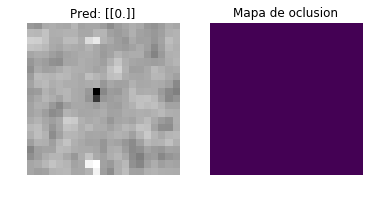

In [53]:
# run the program on image 
nume=0

tiempo_inicial = time() 
print('El tiempo de ejecucion fue:',tiempo_ejecucion)
heatmapList, index, label = gen_heatmap(nume,verbose=False)
print('Clase real: '+str(y_test[nume]))
processed   = post_process(heatmapList)
tiempo_final = time() 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 


%matplotlib inline
img = x_test[nume]
plt.subplot(121)
plt.imshow(img[:,:,3],cmap="gray"); plt.axis("off")
plt.title("Pred: "+str(classifier.predict(x_test[nume:nume+1])))
plt.subplot(122)
plt.imshow(processed); plt.axis("off")
plt.title('Mapa de oclusion')
plt.show()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y_pred = classifier.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
target_names = ['No-supernova', 'Supernova']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[3959    0]
 [4041    0]]
Classification Report
              precision    recall  f1-score   support

No-supernova       0.49      1.00      0.66      3959
   Supernova       0.00      0.00      0.00      4041

   micro avg       0.49      0.49      0.49      8000
   macro avg       0.25      0.50      0.33      8000
weighted avg       0.24      0.49      0.33      8000



C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
